In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# ### 데이터 분석, 시각화, 머신러닝 모델 학습 및 평가를 위한 라이브러리 로드

In [62]:
# 1. 데이터 로드: 와인 품질 데이터셋 불러오기
wine_df = pd.read_csv('./data/WineQT.csv')
print(f"최초 데이터 크기: {wine_df.shape}")

# 2. 분석에 필요 없는 Id 컬럼 제거: 개별 샘플의 식별자는 학습에 불필요하므로 삭제
if 'Id' in wine_df.columns:
    wine_df = wine_df.drop('Id', axis=1)
print(f"Id 제거 후 크기: {wine_df.shape}")

# 3. 특정 Quality(3, 4, 8) 데이터 삭제: 샘플 수가 너무 적어 학습에 방해가 되는 등급 제거
target_quality = [3, 4, 8]
wine_df = wine_df[~wine_df['quality'].isin(target_quality)]

# 삭제 후 결과 확인: 5, 6, 7 등급 위주로 구성됨을 확인
print(f"Quality(3, 4, 8) 삭제 후 크기: {wine_df.shape}")
print(f"남은 품질 등급: {wine_df['quality'].unique()}")

wine_df.head()

최초 데이터 크기: (1143, 13)
Id 제거 후 크기: (1143, 12)
Quality(3, 4, 8) 삭제 후 크기: (1088, 12)
남은 품질 등급: [5 6 7]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


1 - 고정 산도
2 - 휘발성 산도
3 - 구연산
4 - 잔류당
5 - 염화물
6 - 이산화황이 없는
7 - 총 이산화황
8 - 밀도
9 - pH
10 - 황산염
11 - 알코올
12 - 품질

In [63]:
# 퀄리티를 3단계(Low, Medium, High)로 나누는 함수 정의
# 6단계로 세분화 시 데이터 불균형으로 인한 학습 저하를 막기 위함
def quality_group(q):
    if q <= 4:
        return 0   # low (3, 4점 대상 - 현재는 데이터 삭제됨)
    elif q <= 6:
        return 1   # medium (5, 6점 대상)
    else:
        return 2   # high (7점 이상 대상)

# quality_group 컬럼 새로 생성
wine_df['quality_group'] = wine_df['quality'].apply(quality_group)

In [64]:
# 입력 데이터(X)에서 원본 quality와 새로 만든 group 컬럼 제외
X = wine_df.drop(columns=['quality', 'quality_group']).to_numpy()
y = wine_df['quality_group'].to_numpy() # 타겟 데이터로 그룹화된 등급 사용

print(X.shape, y.shape)

# 학습용과 테스트용 데이터 8:2 분할 (stratify를 통해 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1088, 11) (1088,)
(870, 11) (870,)
(218, 11) (218,)


In [65]:
# 결측치 존재 여부 및 컬럼별 데이터 타입(Dtype) 최종 확인
print(wine_df.info())

<class 'pandas.DataFrame'>
Index: 1088 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1088 non-null   float64
 1   volatile acidity      1088 non-null   float64
 2   citric acid           1088 non-null   float64
 3   residual sugar        1088 non-null   float64
 4   chlorides             1088 non-null   float64
 5   free sulfur dioxide   1088 non-null   float64
 6   total sulfur dioxide  1088 non-null   float64
 7   density               1088 non-null   float64
 8   pH                    1088 non-null   float64
 9   sulphates             1088 non-null   float64
 10  alcohol               1088 non-null   float64
 11  quality               1088 non-null   int64  
 12  quality_group         1088 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 119.0 KB
None


###  변수간 관계 분석

In [ ]:
# 알코올 도수가 품질 점수에 미치는 영향 분석
# 일반적으로 상관계수가 가장 높게 나타나는 변수
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', data=wine_df, hue='quality', palette='Set2', legend=False)
plt.title('Alcohol Content by Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Alcohol (%)')
plt.show()
# 품질 점수가 높아질수록 알코올 도수의 중앙값이 상승하는 경향이 있는지 확인.

# ----------------------------------------------------------------------#

# 휘발성 산도(식초 맛)가 품질에 미치는 부정적 영향 분석
# 보통 품질과 강한 음(-)의 상관관계를 가진다.
plt.figure(figsize=(10, 6))
sns.violinplot(x='quality', y='volatile acidity', data=wine_df, hue='quality', palette='coolwarm', legend=False)
plt.title('Volatile Acidity by Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Volatile Acidity')
plt.show()
#  저품질 와인(5점)에서 휘발성 산도 수치가 높게 나타나는지 확인.
# 산도가 너무 높으면 와인이 상한 맛을 내기 때문에 품질이 급격히 떨어진다.

# ----------------------------------------------------------------------#

# 두 산성 성분 간의 선형 관계 분석
# 화학적으로 밀접한 두 변수가 얼마나 강한 상관관계를 가지는지 산점도로 확인.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='citric acid', hue='quality', data=wine_df, palette='viridis')
plt.title('Citric Acid vs Fixed Acidity')
plt.xlabel('Fixed Acidity')
plt.ylabel('Citric Acid')
plt.show()
# 고정 산도가 높을수록 구연산 함량도 높아지는 양의 선형 관계가 있는지 확인.
# 점의 색상(Quality)을 통해 고품질 와인들이 특정 구역에 몰려 있는지도 파악할 수 있다.

In [66]:
# 3단계 분류 그룹화 전, 원본 데이터의 등급별 샘플 수 파악
wine_df['quality'].value_counts()

quality
5    483
6    462
7    143
Name: count, dtype: int64

In [67]:
# 표준화(StandardScaler): 평균 0, 표준편차 1로 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
# 새롭게 정의한 3단계 등급(0, 1, 2)의 샘플 수 확인
wine_df['quality_group'].value_counts()

quality_group
1    945
2    143
Name: count, dtype: int64

In [69]:
# RandomForest의 최적 파라미터 조합 설정
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'n_estimators': [10, 50, 100]
}

# 5-폴드 교차 검증을 통해 최적의 모델 찾기
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# 교차 검증 상세 결과를 데이터프레임으로 저장
cv_results_df = pd.DataFrame(grid.cv_results_)

In [70]:
# 각 조합별 성능(mean_test_score 등) 확인
cv_results_df = pd.DataFrame(grid.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012323,0.005878,0.001293,0.001099,None,10,"{'max_depth': None, 'n_estimators': 10}",0.919540,0.879310,0.896552,0.908046,0.902299,0.901149,0.013306,7
1,0.041738,0.001066,0.002436,0.000439,None,50,"{'max_depth': None, 'n_estimators': 50}",0.913793,0.896552,0.913793,0.885057,0.908046,0.903448,0.011144,5
2,0.081711,0.002576,0.004064,0.000040,None,100,"{'max_depth': None, 'n_estimators': 100}",0.908046,0.902299,0.919540,0.890805,0.908046,0.905747,0.009338,1
3,0.008950,0.001100,0.000634,0.000021,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.908046,0.885057,0.890805,0.885057,0.896552,0.893103,0.008602,10
4,0.036934,0.000816,0.002178,0.000062,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.902299,0.896552,0.885057,0.890805,0.890805,0.893103,0.005861,10
5,0.071020,0.000673,0.003885,0.000140,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.896552,0.885057,0.885057,0.890805,0.885057,0.888506,0.004598,12
6,0.008575,0.000224,0.000710,0.000128,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.913793,0.856322,0.908046,0.896552,0.896552,0.894253,0.020107,9
7,0.041102,0.001301,0.002197,0.000019,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.919540,0.890805,0.931034,0.879310,0.902299,0.904598,0.018747,3
8,0.079522,0.000721,0.003985,0.000050,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.896552,0.902299,0.919540,0.896552,0.902299,0.903448,0.008447,5
9,0.008334,0.000072,0.000664,0.000029,15,10,"{'max_depth': 15, 'n_estimators': 10}",0.919540,0.879310,0.896552,0.908046,0.902299,0.901149,0.013306,7


In [71]:
# 1️⃣ 이진 라벨 생성: 6점 이상을 1(Good), 미만을 0(Bad)으로 설정
wine_df["quality_binary"] = (wine_df["quality"] >= 6).astype(int)

# 2️⃣ X, y 재정의: 품질 점수 관련 컬럼을 제외하고 모델 입력 정의
X = wine_df.drop(columns=["quality", "quality_binary", "quality_group"]).values
y = wine_df["quality_binary"].values

# 3️⃣ 이진 분류용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4️⃣ MinMaxScaler 적용: 데이터 범위를 0~1 사이로 정규화
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ 이진 분류 모델 학습 (최적 깊이 15, 트리 50개 설정)
rf = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [72]:
# 예측 수행 및 평가지표(Precision, Recall, F1-score) 출력
y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# ### 인사이트: 데이터 불균형으로 인해 하위 등급 예측이 미흡함을 확인

              precision    recall  f1-score   support

           0       0.81      0.75      0.78        97
           1       0.81      0.86      0.84       121

    accuracy                           0.81       218
   macro avg       0.81      0.81      0.81       218
weighted avg       0.81      0.81      0.81       218



In [73]:
# -----------------------------
# 1. 기본 모델 학습 및 평가
# -----------------------------
rf_default = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf_default.fit(X_train_scaled, y_train)
y_pred_default = rf_default.predict(X_test_scaled)

print("===== Default RandomForest =====")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

# -----------------------------
# 2. class_weight='balanced' 적용 모델: 부족한 클래스에 가중치를 주어 학습 보완
# -----------------------------
rf_balanced = RandomForestClassifier(
    max_depth=15,
    n_estimators=50,
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(X_train_scaled, y_train)
y_pred_balanced = rf_balanced.predict(X_test_scaled)

print("===== Balanced RandomForest =====")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))

===== Default RandomForest =====
Accuracy: 0.8119266055045872
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        97
           1       0.81      0.86      0.84       121

    accuracy                           0.81       218
   macro avg       0.81      0.81      0.81       218
weighted avg       0.81      0.81      0.81       218

===== Balanced RandomForest =====
Accuracy: 0.8440366972477065
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        97
           1       0.84      0.88      0.86       121

    accuracy                           0.84       218
   macro avg       0.84      0.84      0.84       218
weighted avg       0.84      0.84      0.84       218



클래스 불균형 문제를 해결하기 위해 class_weight='balanced'를 적용했으나, 소수 클래스의 샘플 수가 매우 적어 성능 개선 효과는 미미하였다.

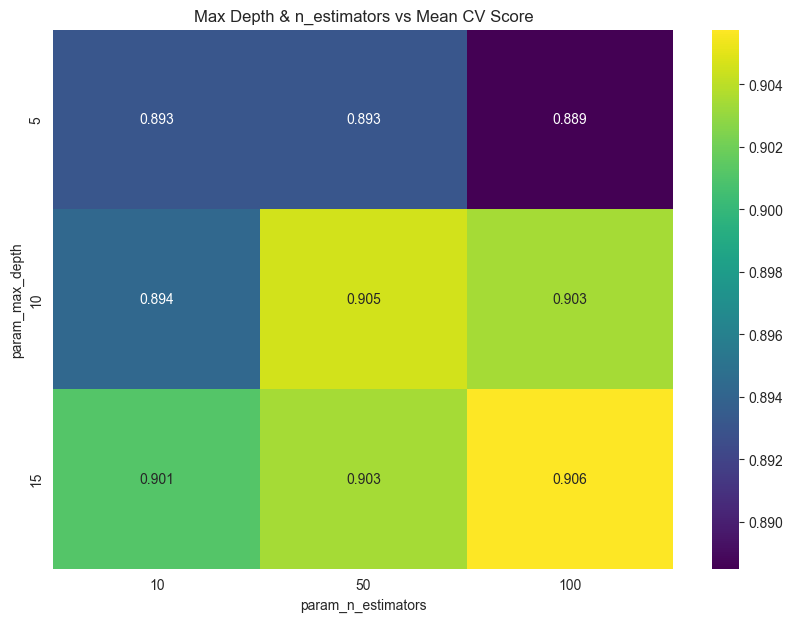

Best Params: {'max_depth': None, 'n_estimators': 100}
Best CV Score: 0.9057471264367816


In [74]:
# 그리드 서치 결과를 피벗 테이블로 변환하여 성능 흐름 시각화
cv_pivot = cv_results_df.pivot_table(
    columns='param_n_estimators',
    index='param_max_depth',
    values='mean_test_score',
)

# 히트맵 그리기: 트리 깊이와 개수가 정확도에 미치는 영향 파악
plt.figure(figsize=(10, 7))
sns.heatmap(cv_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Max Depth & n_estimators vs Mean CV Score")
plt.show()

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

RandomForest는 여러 트리의 평균을 사용하기 때문에 깊은 트리에서도 과적합이 완화되며, max_depth=15, n_estimators=50 조합에서 가장 높은 평균 교차검증 정확도(0.857)를 보였다.

In [75]:
# 그리드 서치에서 발견된 가장 좋은 성능의 모델 객체 저장
best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'max_depth': None, 'n_estimators': 100}
Best CV Score: 0.9057471264367816


In [76]:
# 이진 라벨 생성 및 분할 과정이 정확한지 다시 한번 확인
wine_df["quality_binary"] = (wine_df["quality"] >= 6).astype(int)
X = wine_df.drop(columns=["quality", "quality_binary", "quality_group"]).values
y = wine_df["quality_binary"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Unique labels after split:", set(y_test)) # 테스트 셋의 라벨(0, 1) 확인

Unique labels after split: {np.int64(0), np.int64(1)}


Accuracy: 0.8119266055045872
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        97
           1       0.81      0.86      0.84       121

    accuracy                           0.81       218
   macro avg       0.81      0.81      0.81       218
weighted avg       0.81      0.81      0.81       218



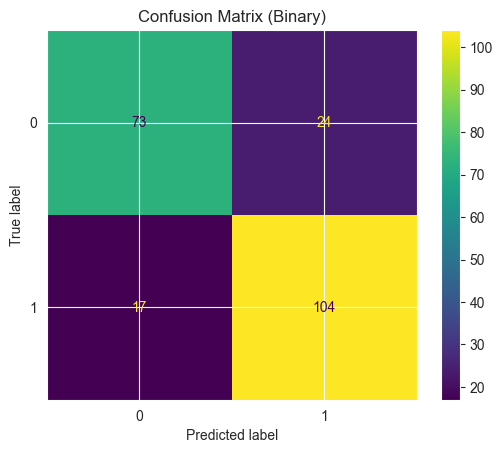

In [77]:
# 최종 학습 및 성능 지표 시각화
wine_df["quality_binary"] = (wine_df["quality"] >= 6).astype(int)
X = wine_df.drop(columns=["quality", "quality_binary", "quality_group"]).values
y = wine_df["quality_binary"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 혼동 행렬 시각화: 모델이 어느 등급을 헷갈려 하는지 시각적으로 파악
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix (Binary)")
plt.show()

와인 품질 점수를 세 단계로 예측하는 것은 어려웠으나, 이를 2단계(좋음/보통) 이진분류로 재구성한 결과 정확도와 클래스 균형 성능이 크게 향상되었다.